Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.
<br>

#### Описание проекта
Данные находятся в трёх файлах:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

<br>Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
<br>Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
<br>В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.
Инструкция по выполнению проекта





***Описание данных***

*Технологический процесс:*
*	Rougher feed — исходное сырье
*	Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
*	Xanthate — ксантогенат (промотер, или активатор флотации);
*	Sulphate — сульфат (на данном производстве сульфид натрия);
*	Depressant — депрессант (силикат натрия).
*	Rougher process (англ. «грубый процесс») — флотация
*	Rougher tails — отвальные хвосты
*	Float banks — флотационная установка
*	Cleaner process — очистка
*	Rougher Au — черновой концентрат золота
*	Final Au — финальный концентрат золота

*Параметры этапов:*
*	air amount — объём воздуха
*	fluid levels — уровень жидкости
*	feed size — размер гранул сырья
*	feed rate — скорость подачи

**Наименование признаков**

*Наименование признаков должно быть такое:*
[этап].[тип_параметра].[название_параметра]
Пример: *rougher.input.feed_ag*
*Возможные значения для блока [этап]:*
*	rougher — флотация
*	primary_cleaner — первичная очистка
*	secondary_cleaner — вторичная очистка
*	final — финальные характеристики
*Возможные значения для блока [тип_параметра]:*
*	input — параметры сырья
*	output — параметры продукта
*	state — параметры, характеризующие текущее состояние этапа
*	calculation — расчётные характеристики


# Восстановление золота из руды

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import  r2_score, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


from sklearn.svm import SVR



### Откроем и изучим файлы.

- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv') 
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')


In [3]:
def all_info(data):
    print('-------------------------------------------------------------------------------------------------------------')
    print('Общая информация:')
    print(data.info())
    print('-----------------------------------------')
    print('-----------------------------------------')
    #print('Cтатистические данные по файлу:')
    #print(data.describe())
    #print('-----------------------------------------')
    #print('Вывод первых пяти строк:')
    #print(data.head())
    #print('-----------------------------------------')
    print('Проверяем наличие дубликатов:')
    print(data.duplicated().sum())
    print('-----------------------------------------')
    print('------------------------------------------')
    #print('Проверяем количество пропущенных значений:')
    #print(data.isnull().sum().sort_values(ascending=False))
    print('-------------------------------------------------------------------------------------------------------------')

#### data_train

In [4]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
print(all_info(data_train))

-------------------------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb         

In [6]:
train_isnulls = pd.DataFrame(data_train.isnull().sum().sort_values(ascending=False))
train_isnulls[train_isnulls[0] > 0]

,0
secondary_cleaner.output.tail_sol,1605
rougher.state.floatbank10_e_air,436
rougher.input.floatbank11_xanthate,428
primary_cleaner.output.concentrate_sol,286
secondary_cleaner.state.floatbank2_a_air,217
...,...
primary_cleaner.output.tail_ag,1
final.output.concentrate_ag,1
rougher.calculation.sulfate_to_au_concentrate,1
rougher.output.tail_ag,1


In [7]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


####  data_test

In [8]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [9]:
print(all_info(data_test))

-------------------------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatban

In [10]:
test_isnulls = pd.DataFrame(data_test.isnull().sum().sort_values(ascending=False))
test_isnulls[test_isnulls[0] > 0]

,0
rougher.input.floatbank11_xanthate,25
rougher.input.feed_sol,21
secondary_cleaner.state.floatbank3_a_air,9
rougher.input.floatbank11_sulfate,8
primary_cleaner.input.depressant,5
rougher.input.floatbank10_sulfate,5
primary_cleaner.input.xanthate,4
primary_cleaner.input.sulfate,4
rougher.input.feed_rate,3
secondary_cleaner.state.floatbank2_a_air,3


In [11]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


#### data_full_new

In [12]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [13]:
print(all_info(data_full))

-------------------------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb         

In [14]:
full_isnulls = pd.DataFrame(data_full.isnull().sum().sort_values(ascending=False))
full_isnulls[full_isnulls[0] > 0]

,0
secondary_cleaner.output.tail_sol,1748
rougher.input.floatbank11_xanthate,453
rougher.state.floatbank10_e_air,436
primary_cleaner.output.concentrate_sol,370
secondary_cleaner.state.floatbank2_a_air,220
...,...
primary_cleaner.state.floatbank8_b_level,1
primary_cleaner.state.floatbank8_a_level,1
primary_cleaner.state.floatbank8_d_level,1
rougher.output.tail_ag,1


In [15]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


***Вывод:*** 
- предоставленные данные довольно объемны как по числу строк, так и по количеству столбцов.
- в каждом датафрейме есть столбец содержащий дату
- в столбцах во всех трех таблицах имеются пропуски, нулевые и отрицательные значения
- практически все данные, кроме дат, имеют численный тип

### Предобработка данных.

**Переводим столбец с датой в нужный верменной формат.**

In [16]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%dT%H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%dT%H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%dT%H:%M:%S')

**Выведем количесво занимаемой памяти для каждого файла.**

In [17]:
def memory(data):
    for dtype in ['float','int','object']:
        selected_dtype = data.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))
print(memory(data_train))
print()
print(memory(data_test))
print()
print(memory(data_full))

Average memory usage for float columns: 0.11 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 0.00 MB
None

Average memory usage for float columns: 0.04 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 0.00 MB
None

Average memory usage for float columns: 0.15 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 0.00 MB
None


*Датафреймы, содержащие обучающую выборку и исходные данные, занимают много памяти, что может сказаться на скорости их обработки. Стоит их сократить без ущерба для данных путем перевода float64 в float32.*

In [18]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: 
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 
    return "{:03.2f} MB".format(usage_mb)

data_float = data_train.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(data_float))
print(mem_usage(converted_float))
print()

compare_floats = pd.concat([data_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

data_float = data_full.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(data_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([data_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

9.28 MB
4.64 MB

12.75 MB
6.38 MB


,before,after
float32,NaN,86.0
float64,86.0,NaN


In [19]:
data_train = data_train.copy()
data_train[converted_float.columns] = converted_float
print(mem_usage(data_train))
print()
data_full = data_full.copy()
data_full[converted_float.columns] = converted_float
print(mem_usage(data_full))
print()

4.75 MB

6.53 MB



***Заполняем пропуски.***

Так как по условию задания известно, что близкие по времени(т е идущие друг за другом в данных датафреймах) данные в экспериментах похожи, логично заполнить пропуски соседним значением в столбце. Для этого применяем метод  "ffill"

In [20]:
data_train=data_train.fillna(value=None, method="ffill") 
data_test=data_test.fillna(value=None, method="ffill") 
data_full=data_full.fillna(value=None, method="ffill") 

In [21]:
print(data_train.isnull().sum().sort_values(ascending=False))
print(data_test.isnull().sum().sort_values(ascending=False))
print(data_full.isnull().sum().sort_values(ascending=False))

date                                          0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_e_air               0
                                             ..
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_b_air        0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64
date                                          0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_clean

***Вывод:*** 
- перевели столбцы с датами в нужный формат: при работе в дальнейшем эти столбцы можно использовать как дополнительные индексы;
- уменьшили объем даннных;
- заполнили пропуски в датафреймах соседним значением в столбце, т к это обосновано заданием, а так же тем, что удаление или заполнение пропусков нулевыми или средними/медианными значениями может повлиять на конечные результаты.

### Проверим, что эффективность обогащения рассчитана правильно. 

***Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Опишите выводы.***

**Расчёт эффективности**
<br>Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды по обучающей выборке.
<br>Эффективность обогащения рассчитывается по формуле:
<br> ***R(ecovery) = (C*(F-T)/F*(C-T))*100%***

* где:
* * C — доля золота в концентрате после флотации/очистки;
* * F — доля золота в сырье/концентрате до флотации/очистки;
* * T — доля золота в отвальных хвостах после флотации/очистки.
<br>Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [22]:
# функция расчитывает Эффективность обогащения
# если в знаменателе 0, меняем на значение из исходной таблицы
def recovery_rougher(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    Calc = row['rougher.output.recovery']
    if (F * (C-T)) == 0: R = Calc
    
    else: R = 100* ((C * (F-T)) / (F * (C-T)))   
    return R

Рассчитаем Recovery для этапа "Флотация":

In [23]:
recovery= data_train
recovery['rougher.calculation.recovery'] = recovery.apply(recovery_rougher,axis=1)

Прежде чем посчитать MAE нужно проверить наличие отсутствующих значений и пропусков:

In [24]:
mae_index = recovery['rougher.output.recovery'].notna()
# проверим количество пропусков:
print(recovery.loc[mae_index]['rougher.calculation.recovery'].isna().sum())
print(recovery.loc[mae_index]['rougher.output.recovery'].isna().sum())

0
0


Пропусков нет, запускаем функцию:

In [25]:
mean_absolute_error(recovery.loc[mae_index]['rougher.output.recovery'], recovery.loc[mae_index]['rougher.calculation.recovery'])

1.9727487074604263e-06

***Вывод:***
Значение MAE достаточно низкое, можно сказать, что наши расчеты совпадают с признаком rougher.output.recovery. Данную формулу можно использовать в дальнейшем при расчетах. 

***Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?***

In [26]:
#Признаки в тестовой выборке
test_col=data_test.columns
#Признаки в полной выборке
full_col=data_full.columns
#Разница признаков. 
main_list=list(set(full_col)-set(test_col))
# Этих признаков нет в тестовой выборке
main_list=pd.Series(main_list)
main_list.sort_values()

23                          final.output.concentrate_ag
30                          final.output.concentrate_au
24                          final.output.concentrate_pb
0                          final.output.concentrate_sol
31                                final.output.recovery
12                                 final.output.tail_ag
2                                  final.output.tail_au
18                                 final.output.tail_pb
20                                final.output.tail_sol
5                 primary_cleaner.output.concentrate_ag
22                primary_cleaner.output.concentrate_au
4                 primary_cleaner.output.concentrate_pb
1                primary_cleaner.output.concentrate_sol
28                       primary_cleaner.output.tail_ag
10                       primary_cleaner.output.tail_au
3                        primary_cleaner.output.tail_pb
8                       primary_cleaner.output.tail_sol
17                      rougher.calculation.au_p

***Вывод:*** Можно считать выведенные данные выходными признаками(выходные концентрации веществ на разных этапах, выходные концентрации отвальных хвостов, расчетны характеристики на этапе флотации  после каждого технологического этапа и др.). Каждый из этих признаков можно сделать целевым и предсказывать. Тут присутствуют и наши целевые признаки final.output.recovery и rougher.output.recovery. В дальнейшем они понадобятся на этапе подсчета метрики sMAPE.

## Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.


Разделим данные по концентрациям металлов на разных этапах очистки:


In [27]:
print('Флострация концетрации au:', data_full['rougher.output.concentrate_au'].mean())
print('Первичная очистка концетрации au:', data_full['primary_cleaner.output.concentrate_au'].mean())
print('Финальная концетрация au:', data_full['final.output.concentrate_au'].mean())
print()
print('Флострация концетрации ag:', data_full['rougher.output.concentrate_ag'].mean())
print('Первичная очистка концетрации ag:', data_full['primary_cleaner.output.concentrate_ag'].mean())
print('Финальная концетрация ag:', data_full['final.output.concentrate_ag'].mean())
print()
print('Флострация концетрации pb:', data_full['rougher.output.concentrate_pb'].mean())
print('Первичная очистка концетрации pb:', data_full['primary_cleaner.output.concentrate_pb'].mean())
print('Финальная концетрация pb:', data_full['final.output.concentrate_pb'].mean())

Флострация концетрации au: 19.772001
Первичная очистка концетрации au: 32.1194
Финальная концетрация au: 44.07651

Флострация концетрации ag: 11.9947605
Первичная очистка концетрации ag: 8.442408
Финальная концетрация ag: 5.1683865

Флострация концетрации pb: 7.606272
Первичная очистка концетрации pb: 9.810317
Финальная концетрация pb: 9.978822


**Визуализируем:**

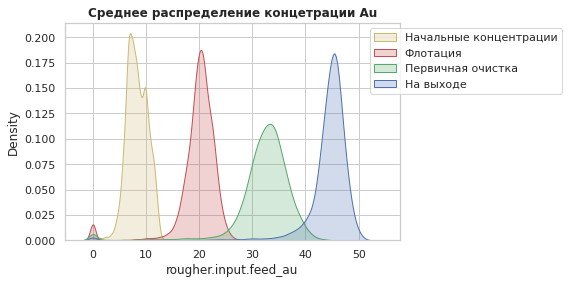

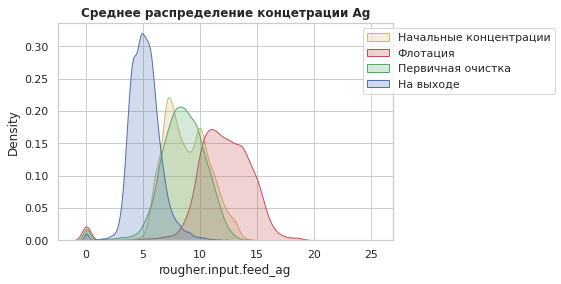

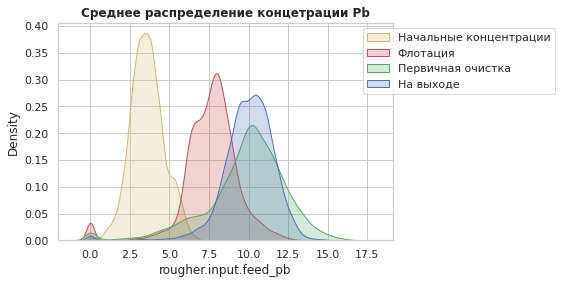

In [28]:
# set seaborn darkgrid theme 
sns.set(style="whitegrid")

# density plot
plt.title('Среднее распределение концетрации Au', fontweight='bold')
fig = sns.kdeplot(data_full['rougher.input.feed_au'],color='y', legend=True,shade=True)

fig = sns.kdeplot(data_full['rougher.output.concentrate_au'],color='r', legend=True,shade=True)
fig = sns.kdeplot(data_full['primary_cleaner.output.concentrate_au'],color='g', legend=True,shade=True)
fig = sns.kdeplot(data_full['final.output.concentrate_au'],color='b', legend=True,shade=True)
plt.legend(['Начальные концентрации', 'Флотация', 'Первичная очистка', "На выходе" ], loc=1, bbox_to_anchor=(1.5, 1))     
plt.show()
plt.title('Среднее распределение концетрации Ag', fontweight='bold')
fig = sns.kdeplot(data_full['rougher.input.feed_ag'],color='y', legend=True,shade=True)
fig = sns.kdeplot(data_full['rougher.output.concentrate_ag'],color='r', legend=True,shade=True)
fig = sns.kdeplot(data_full['primary_cleaner.output.concentrate_ag'],color='g', legend=True,shade=True)
fig = sns.kdeplot(data_full['final.output.concentrate_ag'],color='b', legend=True,shade=True)
plt.legend(['Начальные концентрации','Флотация', 'Первичная очистка', "На выходе" ], loc=1, bbox_to_anchor=(1.5, 1))     
plt.show()

plt.title('Среднее распределение концетрации Pb', fontweight='bold')
fig = sns.kdeplot(data_full['rougher.input.feed_pb'],color='y', legend=True,shade=True)
fig = sns.kdeplot(data_full['rougher.output.concentrate_pb'],color='r', legend=True,shade=True)
fig = sns.kdeplot(data_full['primary_cleaner.output.concentrate_pb'],color='g', legend=True,shade=True)
fig = sns.kdeplot(data_full['final.output.concentrate_pb'],color='b', legend=True,shade=True)
plt.legend(['Начальные концентрации','Флотация', 'Первичная очистка', "На выходе" ], loc=1, bbox_to_anchor=(1.5, 1))     
plt.show()

**Вывод:** Стабильно высокие показатели концентрации на выходе на разных этапах работы у свинца - вероятно, это говорит о том, что его легче отделить в большем объеме от руды или же его количество в руде больше количества серебра. 
На каждом из графиков видны аномальные значения в нуле. Вероятно это отвальные хвосты каждого элемента или же дефект данных. Также на графике концетрации Au можно заметить нормальное распределение велечин, а на графиках Ag и Pb бимодальное распределение. Значение у Au много больше, чем у остальных, что логично.</font>

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

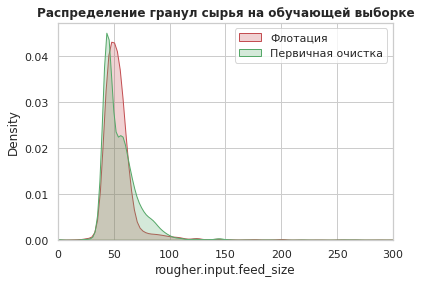

In [29]:
plt.title('Распределение гранул сырья на обучающей выборке', fontweight='bold')
fig = sns.kdeplot(data_train['rougher.input.feed_size'],color='r', legend=True,shade=True)
fig = sns.kdeplot(data_test['rougher.input.feed_size'],color='g', legend=True,shade=True)
plt.legend(['Флотация', 'Первичная очистка'], loc=1)     
plt.xlim(0, 300)
plt.show()

In [30]:
feed_size_avg_train = data_train['rougher.input.feed_size'].mean()
print('Среднее распределение гранул на обучающей выборке:',feed_size_avg_train)
feed_size_avg_test = data_test['rougher.input.feed_size'].mean()
print('Среднее распределение гранул на тестовой выборке:',feed_size_avg_test)

Среднее распределение гранул на обучающей выборке: 55.4825
Среднее распределение гранул на тестовой выборке: 55.952754028895136


**Вывод:** Распределения практически не отличаются друг от друга - оценка модели правильная

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.


In [31]:
data_train1=data_train
data_train1=data_train1.dropna()
data_train1['raw']=data_train['rougher.input.feed_au']+data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']#сырье
data_train1['rough']=data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_au']#черновой
data_train1['primary']=data_train['primary_cleaner.output.concentrate_au']+data_train['primary_cleaner.output.concentrate_ag']+data_train['primary_cleaner.output.concentrate_pb']#первичная
data_train1['final']=data_train['final.output.concentrate_au']+data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']#финальная


data_train1=data_train1.query('rough > 20 & raw>20 & final>20 & primary >20')


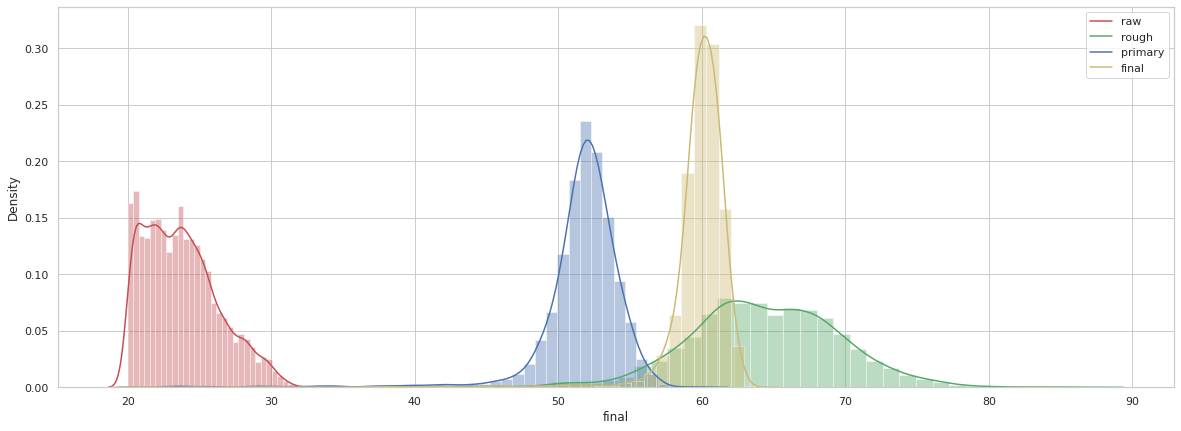

In [32]:
fig = plt.subplots(figsize=(20, 7))
fig = sns.distplot(a=data_train1['raw'], hist=True, kde=True, rug=False , color="r")
fig = sns.distplot(a=data_train1['rough'], hist=True, kde=True, rug=False , color="g")
fig = sns.distplot(a=data_train1['primary'], hist=True, kde=True, rug=False , color="b")
fig = sns.distplot(a=data_train1['final'], hist=True, kde=True, rug=False , color="y")
plt.legend(['raw', 'rough', 'primary', 'final'], loc=1)
plt.show()

**Вывод:** как и ожидается, на финальном этапе концетрата становится значительно меьше по сравнению со входом. 
Показатели по этапам суммы концетрата имеют нормальное распределение, кромеу сырьевого концетрата - ему соответствует многомодальное распределение, что свидетельствует о неоднородности данных. Также присутвуют аномальные значения в нуле, но, как было сказано, обработать их не выйдет без существенного влияния на конечный результат. </font>

## Модель

### Построим модель


#### Сформируем функцию для вычисления итоговой sMAPE.


In [33]:
def sMAPE(predict,target):
    predict_rougher=predict[:,0]
    target__rougher=target[:,0]
    predict_final=predict[:,1]
    target__final=target[:,1]
    
    sMAPE_rougher=np.sum(abs(target__rougher-predict_rougher)/((abs(target__rougher)+abs(predict_rougher))/2))
    sMAPE_rougher=sMAPE_rougher/len(target__rougher)*100
    
   
    sMAPE_final=np.sum(abs(target__final-predict_final)/((abs(target__final)+abs(predict_final))/2))
    sMAPE_final=sMAPE_final/len(target__final)*100
    
    sMAP=0.25*sMAPE_rougher+0.75*sMAPE_final
    return sMAP

#### Обучим разные модели и ценим их качество кросс-валидацией.

*Формируем необходимые выборки:*

In [34]:
columns=data_test.columns # Колонки которые в тестовой выборке
feature=data_train[columns] # Формируем признаки Выбираем из trian только те колонки, которые есть в test
feature=feature.drop(['date'],axis=1)
target=data_train[['rougher.output.recovery','final.output.recovery']] # Формируем вектор целевых признаков
target_array=np.array(target) # конвертирую в array
sample_size=int(len(target)/6)

***Линейная регрессия***

In [35]:
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
   
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
    model_regression=LinearRegression().fit(feature_train,target_train)
    prediction_regress=model_regression.predict(feature_valid)   
    
    mae=mean_absolute_error(prediction_regress,target_valid)
    mae_score.append(mae)
    smape=sMAPE(prediction_regress,target_valid_arr)
    smape_score.append(smape)
    
    #print(mae_score)

print(np.mean(mae_score))
print(np.mean(smape_score))

7.003981
10.69644158921606


***Модель "Случайный лес"***

In [36]:
mae_score=[]
smape_score=[]
mae_score=[]
smape_score=[]
par = { 'MAE':[] , 'sMAPE':[], 'max_depth':[]}
df_par = pd.DataFrame(par)


for i in range(0,len(target),sample_size):
    
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    for i in range(1, 5 ):
        
        model_forest=RandomForestRegressor(random_state=1234,max_depth=i, n_estimators=5).fit(feature_train,target_train)
        prediction_forest=model_forest.predict(feature_valid)
        mae=mean_absolute_error(prediction_forest,target_valid)
        mae_score.append(mae)
        smape=sMAPE(prediction_forest,target_valid_arr)
        smape_score.append(smape)
        
        #print('max_depth:',i,'MAE:',np.mean(mae_score))
        #print('max_depth:',i,'sMAPE:',np.mean(smape_score))
        df_par.loc[len(df_par.index)] = [np.mean( mae_score), np.mean(smape_score), i]

        
print(df_par.sort_values('sMAPE').head()) 

         MAE     sMAPE  max_depth
11  6.108271  9.451952        4.0
12  6.201214  9.537843        1.0
10  6.202081  9.582217        3.0
13  6.261059  9.587999        2.0
14  6.298223  9.621164        3.0


***Лучшее значение  sMAPE при n_estimators= 5, max_depth= 4***

 **Берем значение max_depth=3 и n_estimators=4 по результатам предыдущих вычислений**

In [37]:
mae_score=[]
smape_score=[]
for i in range(0,len(target),sample_size):
    
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
        
    model_forest=RandomForestRegressor(random_state=1234,max_depth=4, n_estimators=5).fit(feature_train,target_train)
    prediction_forest=model_forest.predict(feature_valid)
    mae=mean_absolute_error(prediction_forest,target_valid)
    mae_score.append(mae)
    smape=sMAPE(prediction_forest,target_valid_arr)
    smape_score.append(smape)
        
print('MAE:',np.mean(mae_score))
print('sMAPE:',np.mean(smape_score))

MAE: 6.817446254805605
sMAPE: 10.467520788668496


**Вывод:** Используем модель "Случайный лес" как покозавшую лучший результат по сравнению с линейной регрессией. Примененные гиперпараметры: max_depth=4, n_estimators=5. 



***DummyRegressor***

In [38]:
mae_score_dum=[]
smape_score_dum=[]
for i in range(0,len(target), sample_size):
    valid_index=feature.iloc[i:i+sample_size].index
    
    train_index=feature.query('index not in @valid_index').index
    
    target_valid=target.iloc[valid_index]
   
    feature_valid=feature.iloc[valid_index]
    
    target_train=target.iloc[train_index]
    feature_train=feature.iloc[train_index]
    
    target_valid_arr=np.array(target_valid)
    
    dummy_regr = DummyRegressor(strategy = 'quantile', quantile = 0.5 ).fit(feature_train,target_train)
    prediction_regress=dummy_regr.predict(feature_valid)   
    dummy_regr.score(feature_train,target_train)

    mae=mean_absolute_error(prediction_regress, target_valid)
    mae_score_dum.append(mae)
    smape=sMAPE(prediction_regress,target_valid_arr)
    smape_score_dum.append(smape)
    

print(np.mean(mae_score_dum))
print(np.mean(smape_score_dum))
#strategy="mean" strategy = 'quantile', quantile = 0.5

7.328752353727839
11.287125694737512


### Выберем лучшую модель и проверим её на тестовой выборке. 

*Сформируем тестовый набор данных:*

In [39]:
target_test=data_full[['date','rougher.output.recovery','final.output.recovery']]
test_df=data_test.merge(target_test,on=['date'],how='left')
test_df=test_df.dropna()
target_test=test_df[['rougher.output.recovery','final.output.recovery']]
feature_test=test_df.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)

### Сравним модели.

In [40]:
#Случайный лес
prediction_forest=model_forest.predict(feature_test)
smape_forest=sMAPE(prediction_forest,np.array(target_test))
smape_forest

8.619990720525443

In [41]:
#Линейная регрессия
prediction_reg=model_regression.predict(feature_test)
smape_line=sMAPE(prediction_reg,np.array(target_test))
smape_line

9.287642877418941

In [42]:
#DummyRegressor
dummy_prediction=dummy_regr.predict(feature_test)
smape_dummy=sMAPE(dummy_prediction,np.array(target_test))
smape_dummy


9.827701429901701

In [43]:
models=['LinearRegression','RandomForestRegressor', 'DummyRegressor']
sMAPE_rezult=pd.DataFrame(np.array([smape_line,smape_forest, smape_dummy]),index=models)
sMAPE_rezult.set_axis(['sMAPE'],axis='columns',inplace=True)
sMAPE_rezult

,sMAPE
LinearRegression,9.287643
RandomForestRegressor,8.619991
DummyRegressor,9.827701


**Вывод:** По сводной таблице видно, что лучше всего себя показала модель "Случайный лес", sMAPE которого сотавило 8,3%.

## Общий вывод.


При работе с проектом: были изучены предоставленные данные, выполнена предобработка: был изменен тип столбца с датами, заполнены пропуски и произведена оценка данных и уменьшение объема выборок посредством смены типа данных. Было выяснено, что значение MAE достаточно низкое и можно сказать, что наши расчеты совпадают с признаком rougher.output.recovery. Предоставленную формулу Recovery можно использовать в дальнейшем при расчетах. Так же, после оценки недоступных в тестовой выборке признаков, можно считать их выходными признаками(выходные концентрации веществ на разных этапах, выходные концентрации отвальных хвостов, расчетны характеристики на этапе флотации после каждого технологического этапа и др.). Каждый из этих признаков можно сделать целевым и предсказывать. Тут присутствуют и наши целевые признаки final.output.recovery и rougher.output.recovery. В дальнейшем они понадобятся на этапе подсчета метрики sMAPE. Затем были проанализированы изменения концентраций металлов в руде на разных этапах обработки, данные были визуализированы. Вывод: стабильно высокие показатели у свинца - вероятно, это говорит о том, что его легче отделить в большем объеме от руды или же его количество в руде больше количества серебра. На каждом из графиков видны аномальные значения в нуле. Вероятно это отвальные хвосты каждого элемента или же дефект данных. Также на графике концетрации Au можно заметить нормальное распределение велечин, а на графиках Ag и Pb бимодальное распределение. Значение у Au много больше, чем у остальных, что логично. При сравнении распределения размеров гранул сырья на обучающей и тестовой выборках стало ясно, что распределения практически не отличаются друг от друга - оценка модели правильная. При исследовании суммарной концентрации всех веществ на разных стадиях - в сырье, в черновом и финальном концентратах - выяснили, что на финальном этапе концетрата становится значительно меьше по сравнению со входом. Показатели по этапам суммы концетрата имеют нормальное распределение, кромеу сырьевого концетрата - ему соответствует многомодальное распределение, что свидетельствует о неоднородности данных. Также присутвуют аномальные значения в нуле, но, как было сказано, обработать их не выйдет без существенного влияния на конечный результат. Далее, тестовый датасет был разбит на необходимые  выборки, был выделены целевые признаки(rougher.output.recovery','final.output.recovery). Далее обучаем модели линейоной регрессии и случайного леса. По результатам вычислений MAE и sMAPE, лучше себя показала модель "Случайный лес". Примененные гиперпараметры: max_depth=3, n_estimators=4. Далее снова проверили обе модели на тестовой выборке и sMAPE RandomForestRegressor = 8,7%, оказалось наиболее перспективным, чтобы рекомендовать эту можель как конечный результат данной работы.